<a href="https://colab.research.google.com/github/RizwanBiswas/pneumonia-detection-using-transfer-learning/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with zipfile.ZipFile('/content/drive/My Drive/chest_xray.zip', 'r') as f:
  f.extractall(path='/content/')

In [0]:
dataset_path = './chest_xray/'
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

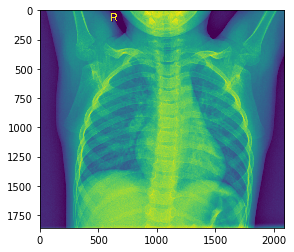

In [6]:
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

In [0]:
def display_image(subset, category, labeled = False, sample_size = 9):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check sample size limit
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(331+i)

    if labeled:
      plt.title(file.split('-'))
        
    plt.imshow(img)

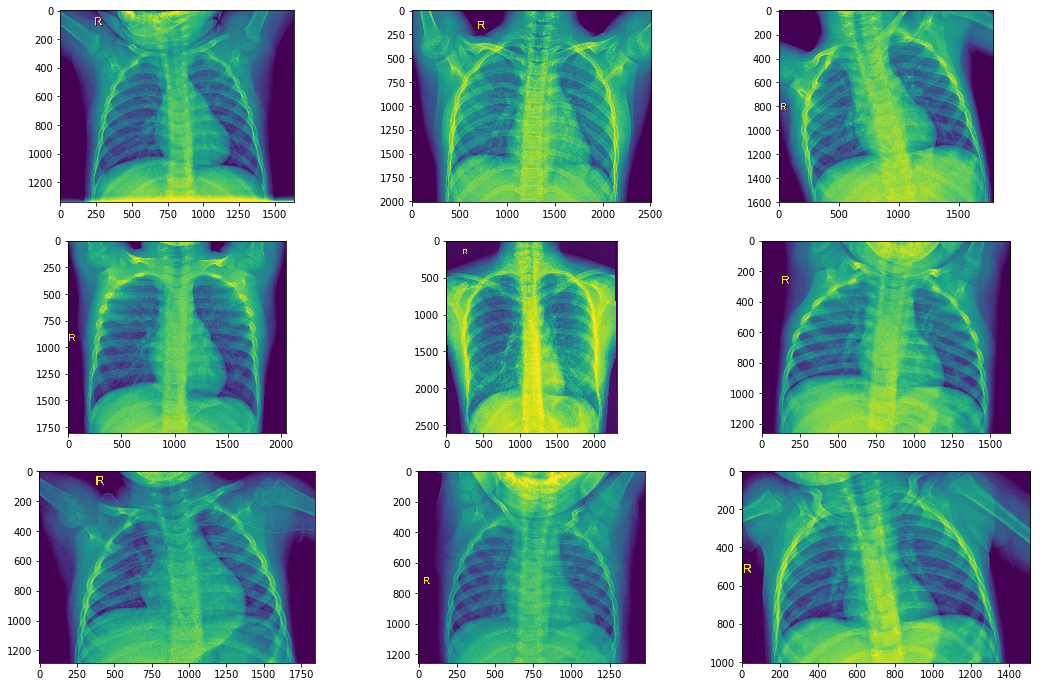

In [36]:
display_image("train", "NORMAL")

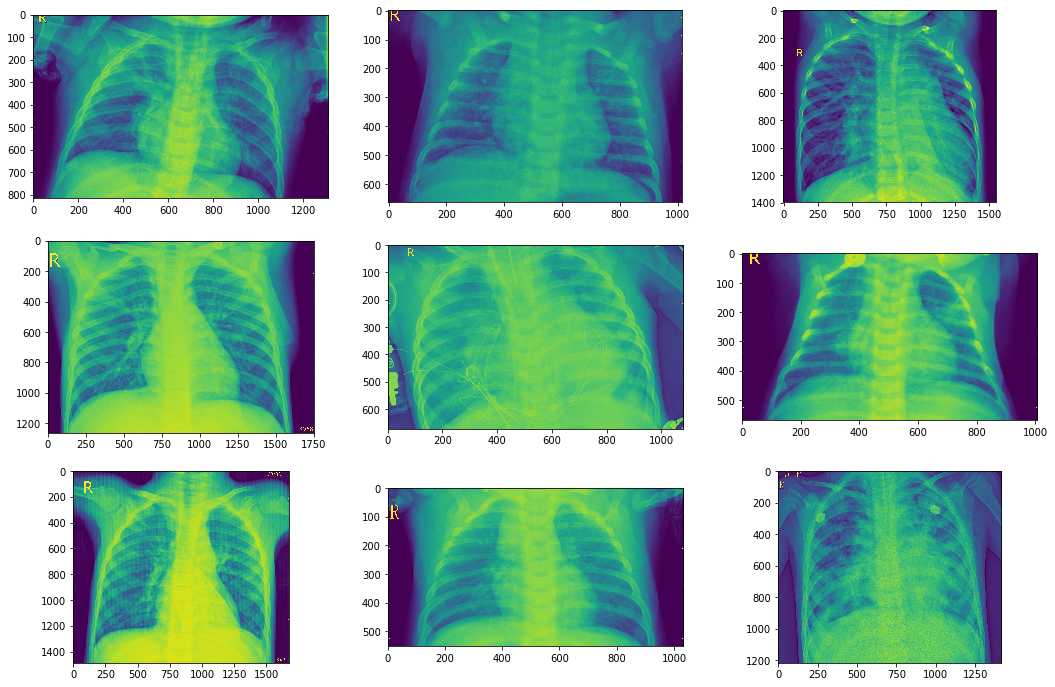

In [37]:
display_image("train", "PNEUMONIA")

In [0]:
def compare_images(subset):
  path = dataset_path + subset
  
  r_pneumonia = np.random.choice(os.listdir(path+"/PNEUMONIA"))
  r_normal = np.random.choice(os.listdir(path+"/NORMAL"))
  
  fig = plt.figure(figsize=(14, 14))
  
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path+"/NORMAL/"+r_normal)
  normal_img = plt.imshow(normal)
  
  a.set_title('NORMAL')
  
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path+"/PNEUMONIA/"+r_pneumonia)
  pneumonia_img = plt.imshow(pneumonia)
  
  a.set_title('PNEUMONIA')
  
  plt.show()
  

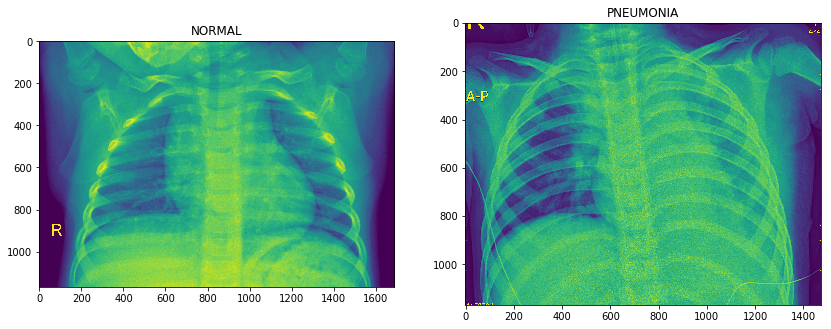

In [49]:
compare_images("train")

In [51]:
#Loading Inception V3
pneumonia_model = tf.keras.applications.InceptionV3(input_shape = (150, 150, 3),
                                              include_top = False,
                                              weights = 'imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 3s 0us/step


In [52]:
pneumonia_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
pneumonia_model.trainable = False

In [0]:
#Custom head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(pneumonia_model.output)

In [0]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

In [0]:
#Defining the model
model = tf.keras.models.Model(inputs=pneumonia_model.input, outputs=prediction_layer)


In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [61]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

train_generator = data_gen_train.flow_from_directory(train_dir, 
                                                     target_size=(150,150), 
                                                     batch_size=128, 
                                                     class_mode="categorical")


valid_generator = data_gen_valid.flow_from_directory(validation_dir,
                                                     target_size=(150,150), 
                                                     batch_size=128, 
                                                     class_mode="categorical")

test_generator = data_gen_valid.flow_from_directory(test_dir,
                                                    target_size=(150,150), 
                                                    batch_size=128, 
                                                    class_mode="categorical")

model.fit_generator(train_generator,
                    epochs = 5,
                    validation_data = valid_generator)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - 62s 2s/step - loss: 0.4891 - acc: 0.7853 - val_loss: 0.8947 - val_acc: 0.3750
Epoch 2/5
41/41 [==============================] - 56s 1s/step - loss: 0.3228 - acc: 0.8691 - val_loss: 1.4374 - val_acc: 0.5000
Epoch 3/5
41/41 [==============================] - 57s 1s/step - loss: 0.2590 - acc: 0.8944 - val_loss: 2.2448 - val_acc: 0.5000
Epoch 4/5
41/41 [==============================] - 56s 1s/step - loss: 0.2423 - acc: 0.9026 - val_loss: 0.6830 - val_acc: 0.6875
Epoch 5/5
41/41 [==============================] - 56s 1s/step - loss: 0.2144 - acc: 0.9147 - val_loss: 0.9056 - val_acc: 0.6875


In [62]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Accuracy: {}".format(valid_accuracy))

Accuracy: 0.6875
